# Contextual Bandits Agent with Policy Gradient Method in Prediction Markets Problem
---
This is a program that simulates an agent who trades in a prediction market. The problem that the prediction market aims to solve is to predict the real distribution of a random variable. We define the random variable as the colour of a bucket. The problem design comes from a human-subjective experiment for decision markets.  

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

In [533]:
import traceback
from scipy.special import expit

In [279]:
class PredictionMarket:
    n_outcomes = 0
    outcomes_list = []
    
    def __init__(self, outcomes_list):
        self.outcomes_list = outcomes_list.copy()
        self.n_outcomes = len(outcomes_list)
        self.init_prediction = np.ones(self.n_outcomes)/ self.n_outcomes
        self.current_prediction = self.init_prediction
        
    def report(self, prediction):
        assert len(prediction) == self.n_outcomes, 'Number of outcomes not fit!'
        assert sum(prediction) == 1, print('Probabilities not sum to one!', prediction)
        # Record the contract if multiple traders.
        self.current_prediction = prediction.copy()
        
    def log_resolve(self, materialised_index):
        assert materialised_index < self.n_outcomes, 'Index out of scope!'
        scores = np.log(self.current_prediction) - np.log(self.init_prediction)
        return scores[materialised_index]

In [280]:
class Bucket:
    
    def __init__(self, prior_red = 0.5):
        assert prior_red >= 0, 'Prior can not be negative!'
        assert prior_red <=1, 'Prior can not greater than one!'
        
        self.prior_red = prior_red
        self.colour = np.random.choice(['red_bucket', 'blue_bucket'], p=(self.prior_red, 1 - self.prior_red))
        if self.colour == 'red_bucket':
            self.ball_list = ['red', 'red', 'blue']
        else:
            self.ball_list = ['blue', 'blue', 'red']
    
    def signal(self):
        return np.random.choice(self.ball_list)

In [1394]:
class Agent:
    
    def __init__(self, feature_shape, learn_rate):
        self.w_mean = np.zeros(feature_shape)
        self.w_std = np.zeros(feature_shape)
        self.learn_rate = learn_rate
        self.reward_history = []
        self.baseline = 0
        self.report_clip = 0.01
        
        # Momentum variables
        self.beta1 = 0.9
        self.v_dw_mean = np.zeros(feature_shape)
        self.v_dw_std = np.zeros(feature_shape)
        
        # RMSprop vaiables
        self.beta2 = 0.999
        self.s_dw_mean = np.zeros(feature_shape)
        self.s_dw_std = np.zeros(feature_shape)
        self.epsilon = 1e-8

    def sigmoid(self, preference):
        return 1/ (1 + np.exp(-preference))
    
    def gaussian(self, x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
    def gradient_approx(self, features, epsilon = 1e-7):
        
        J_plus = np.zeros(self.w_mean.shape)
        J_minus = np.zeros(self.w_mean.shape)
        
        for i in range(J_plus.shape[1]):
            self.w_mean[:, i] += epsilon
            reports = self.report(features)
            J_plus[:, i] = (np.log(reports[0]) - np.log(0.5) )
            self.w_mean[:, i] -= epsilon
            
        for i in range(J_minus.shape[1]):
            self.w_mean[:, i] -= epsilon
            reports = self.report(features)
            J_minus[:, i] = (np.log(reports[0]) - np.log(0.5) )
            self.w_mean[:, i] += epsilon
    
        gradapprox = (J_plus - J_minus)/ (2*epsilon)

        return gradapprox
    
    def report(self, features):
        
        self.features = features
        
        self.means = np.inner(self.w_mean, features)
        self.stds = np.exp(np.inner(self.w_std, features))
        
        self.report_mean = np.mean(self.means)
        self.report_std = np.mean(self.stds)
        
        self.h = np.random.normal(self.report_mean, self.report_std)
        
        self.pi = self.sigmoid(self.h)
        
        if np.isnan(self.pi):
            print('Warning: report is None !!!')
            print('h: ', self.h)
            print('report_mean:', self.report_mean)
            print('report_std:', self.report_std)
            print('means:', self.means)
            print('stds:', self.stds)
            print('features', features)
        
        return [self.pi, 1 - self.pi]
    
    def update(self, rewards, t):
        self.reward_history.append(rewards)
        
        # Baseline term
        self.baseline = self.beta1 * self.baseline + (1 - self.beta1) * (rewards)
        rewards = rewards - self.baseline
        
        gradient_mean = self.features *\
        ((self.h - self.report_mean)/ self.report_std**2) *\
        self.gaussian(self.h, self.report_mean, self.report_std) *\
        (1 - self.pi)
        
        gradient_std = self.features *\
        ((self.h - self.report_mean)**2 / self.report_std**2 - 1) *\
        self.gaussian(self.h, self.report_mean, self.report_std) *\
        (1 - self.pi)
        
        if np.isnan(gradient_mean).any() or np.isnan(gradient_std).any():
            print('Warning: gradients are NaN !!!')
            print('self.h: ', self.h)
            print('self.report_mean: ', self.report_mean)
            print('self.report_std: ', self.stds)
            print('self.pi: ', self.pi)
        
        # momentum update
        self.v_dw_mean = self.beta1 * self.v_dw_mean + (1 - self.beta1) * gradient_mean
        self.v_dw_std = self.beta1 * self.v_dw_std + (1 - self.beta1) * gradient_std
        
        # RMSprop update
        self.s_dw_mean = self.beta2 * self.s_dw_mean + (1 - self.beta2) * (np.power(gradient_mean, 2))
        self.s_dw_std = self.beta2 * self.s_dw_std + (1 - self.beta2) * (np.power(gradient_std, 2))
        
        # bias correction
        rewards_corrected = rewards/ (1 - np.power(self.beta1, t + 1))
        v_dw_mean_corrected = self.v_dw_mean/ (1 - np.power(self.beta1, t + 1))
        v_dw_std_corrected = self.v_dw_std/ (1 - np.power(self.beta1, t + 1))
        s_dw_mean_corrected = self.s_dw_mean/ (1 - np.power(self.beta2, t + 1))
        s_dw_std_corrected = self.s_dw_std/ (1 - np.power(self.beta2, t + 1))
        
        # Only update the corresponding weights
        kernel = self.features
        kernel[:, -1] = 1
        v_dw_mean_corrected = np.multiply(v_dw_mean_corrected, kernel)
        v_dw_std_corrected = np.multiply(v_dw_std_corrected, kernel)
        s_dw_mean_corrected = np.multiply(s_dw_mean_corrected, kernel)
        s_dw_std_corrected = np.multiply(s_dw_std_corrected, kernel)     

        
        # update weights
        
#         # Regular Update 
        self.w_mean += self.learn_rate * rewards_corrected * gradient_mean
        self.w_std += self.learn_rate * rewards_corrected * gradient_std
        
#         # Momentum algorithm
        
#         self.w_mean += self.learn_rate * rewards_corrected * v_dw_mean_corrected
#         self.w_std += self.learn_rate * rewards_corrected * v_dw_std_corrected
        
        # Adam algorithm
#         self.w_mean += self.learn_rate * rewards_corrected * (v_dw_mean_corrected/ (np.sqrt(s_dw_mean_corrected) + self.epsilon) )
#         self.w_std += self.learn_rate * rewards_corrected * (v_dw_std_corrected/ (np.sqrt(s_dw_std_corrected) + self.epsilon))
        
 
        
        
        return [gradient_mean, gradient_std, v_dw_mean_corrected, v_dw_std_corrected, s_dw_mean_corrected, s_dw_std_corrected]

In [1395]:
def OneHotEncode(feature):
    if feature == 'red':
        return np.array([[1, 0]])
    else:
        return np.array([[0, 1]])
    
bucket_colour_to_num = {'red_bucket': 0, 'blue_bucket': 1}

In [1396]:
def gradient_check(agent):

    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    x = np.array([[1, 0, 0.5]])
    report = agent.report(x)
    gradapprox = agent.gradient_approx(x)
    pm.report(report)
    R = pm.log_resolve(0)
    gradient_mean, gradient_std = agent.update(R)
    
    numerator = np.linalg.norm(gradient_mean - gradapprox)                                           # Step 1'
    denominator = np.linalg.norm(gradient_mean) + np.linalg.norm(gradapprox)                                         # Step 2'
    difference = numerator/denominator
    
    if difference > 2e-7:
        print ("\033[93m" + "There is a mistake in the backward propagation! difference = " + str(difference) + "\033[0m")
    else:
        print ("\033[92m" + "Your backward propagation works perfectly fine! difference = " + str(difference) + "\033[0m")
    
    return difference    

In [1415]:
agent = Agent(feature_shape=[1, 3], learn_rate=0.01)
training_episodes = 30000

mean_weights_history = np.empty((1, 3))
std_weights_history = np.empty((1, 3))

r_ball_mean_history = []
b_ball_mean_history = []
r_ball_std_history = []
b_ball_std_history = []

r_ball_pred_history = []
b_ball_pred_history = []

grad_r_ball_mean_history = np.empty((1, 3))
grad_b_ball_mean_history = np.empty((1, 3))
grad_r_ball_std_history = np.empty((1, 3))
grad_b_ball_std_history = np.empty((1, 3))

grad_r_ball_v_mean_history = np.empty((1, 3))
grad_b_ball_v_mean_history = np.empty((1, 3))
grad_r_ball_v_std_history = np.empty((1, 3))
grad_b_ball_v_std_history = np.empty((1, 3))

grad_r_ball_s_mean_history = np.empty((1, 3))
grad_b_ball_s_mean_history = np.empty((1, 3))
grad_r_ball_s_std_history = np.empty((1, 3))
grad_b_ball_s_std_history = np.empty((1, 3))

for t in range(training_episodes):
    prior_red = 0.5
    bucket = Bucket(prior_red)
    pm = PredictionMarket(outcomes_list=['red_bucket', 'blue_bucket'])
    signal = bucket.signal()
    x = np.c_[OneHotEncode(signal), prior_red]
    report = agent.report(x)

    pm.report(report)
    R = pm.log_resolve(bucket_colour_to_num[bucket.colour])
    
#     if signal == 'blue' and t > 0.7 * training_episodes:
#         R *= 0.7
    
    mean_weights_history = np.r_[mean_weights_history, agent.w_mean]
    std_weights_history = np.r_[std_weights_history, agent.w_std]
    
    try:
        grad_mean, grad_std, v_dw_mean_corrected, v_dw_std_corrected, s_dw_mean_corrected, s_dw_std_corrected = agent.update(R, t)
    except ZeroDivisionError:
        tb = traceback.format_exc()
        print(tb)
        
    if signal == 'red':
        r_ball_pred_history.append(report[0])
        r_ball_mean_history.append(agent.report_mean)
        r_ball_std_history.append(agent.report_std)
        grad_r_ball_mean_history = np.r_[grad_r_ball_mean_history, grad_mean]
        grad_r_ball_std_history = np.r_[grad_r_ball_std_history, grad_std]
        ##########
        grad_r_ball_v_mean_history = np.r_[grad_r_ball_v_mean_history, v_dw_mean_corrected]
        grad_r_ball_v_std_history = np.r_[grad_r_ball_v_std_history, v_dw_std_corrected]
        grad_r_ball_s_mean_history = np.r_[grad_r_ball_s_mean_history, s_dw_mean_corrected]
        grad_r_ball_s_std_history = np.r_[grad_r_ball_s_std_history, s_dw_std_corrected]        
    else:
        b_ball_pred_history.append(report[0])
        b_ball_mean_history.append(agent.report_mean)
        b_ball_std_history.append(agent.report_std)
        grad_b_ball_mean_history = np.r_[grad_b_ball_mean_history, grad_mean]
        grad_b_ball_std_history = np.r_[grad_b_ball_std_history, grad_std]
        #########
        grad_b_ball_v_mean_history = np.r_[grad_b_ball_v_mean_history, v_dw_mean_corrected]
        grad_b_ball_v_std_history = np.r_[grad_b_ball_v_std_history, v_dw_std_corrected]
        grad_b_ball_s_mean_history = np.r_[grad_b_ball_s_mean_history, s_dw_mean_corrected]
        grad_b_ball_s_std_history = np.r_[grad_b_ball_s_std_history, s_dw_std_corrected]         
#     mean_history.append(agent.report_mean)
#     std_history.append(agent.report_std)

In [1416]:
# gradient_check(agent)

In [1417]:
agent.stds

array([[0.25652597]])

In [1418]:
agent.w_mean

array([[ 0.73319053, -0.56268011,  0.08525521]])

In [1419]:
agent.w_std

array([[-0.88957141, -0.91223426, -0.90090283]])

Text(0.5, 1.0, 'Rewards')

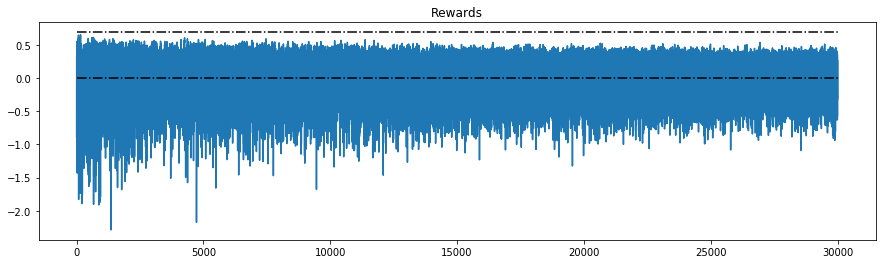

In [1420]:
fig = plt.figure(figsize=(15, 4))
plt.plot(agent.reward_history, zorder = -100)
plt.hlines(y=np.log(2), xmin=0, xmax=len(agent.reward_history), colors='black', linestyles='dashdot')
plt.hlines(y=0.0, xmin=0, xmax=len(agent.reward_history) , colors='black', linestyles='dashdot')
plt.title('Rewards')

14972


Text(0.5, 1.0, 'Report')

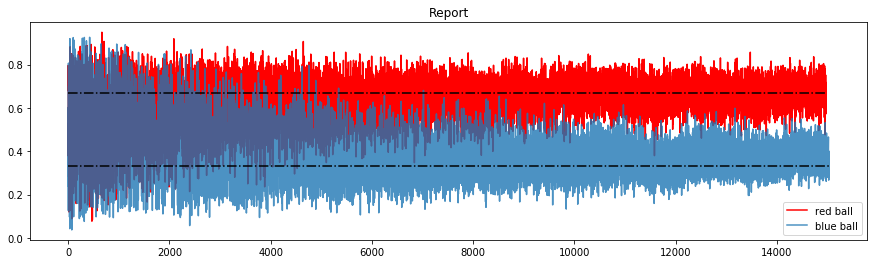

In [1421]:
print(len(r_ball_pred_history))
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_pred_history, 'r',zorder=-100, label='red ball')
plt.plot(b_ball_pred_history, zorder=-99, label = 'blue ball', alpha=0.8)
plt.hlines(y=2/3, xmin=0, xmax=len(r_ball_pred_history), colors='black', linestyles='dashdot')
plt.hlines(y=1/3, xmin=0, xmax=len(b_ball_pred_history) , colors='black', linestyles='dashdot')
plt.legend()
plt.title('Report')

Text(0.5, 1.0, 'Mean')

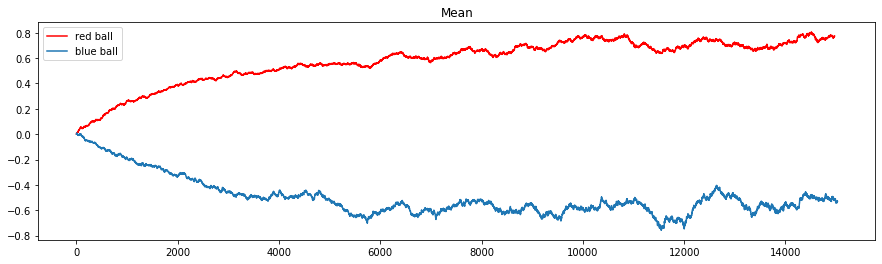

In [1422]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_mean_history, 'r', label = 'red ball')
plt.plot(b_ball_mean_history,label = 'blue ball')
plt.legend()
plt.title('Mean')

Text(0.5, 1.0, 'Weights for Mean')

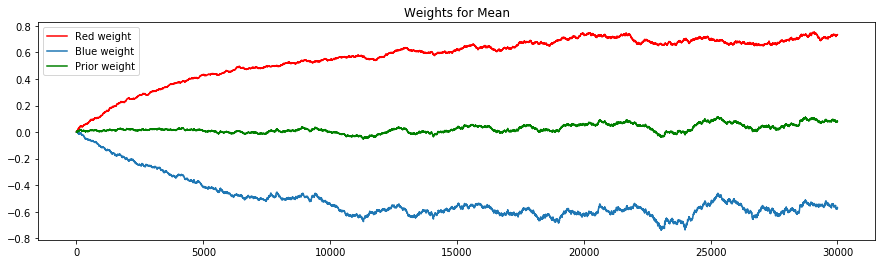

In [1423]:
fig = plt.figure(figsize=(15, 4))
plt.plot(mean_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(mean_weights_history[1:, 1], label='Blue weight')
plt.plot(mean_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for Mean')

Text(0.5, 1.0, 'Standard Diviation')

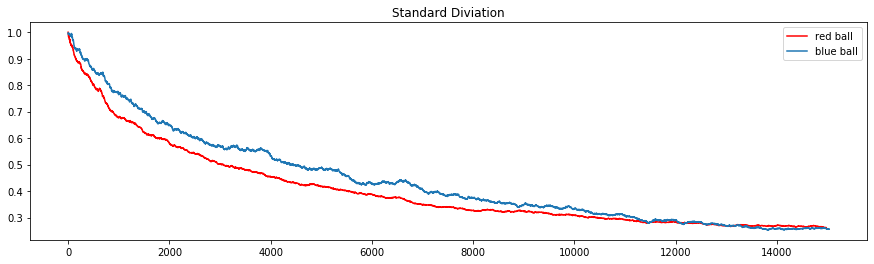

In [1424]:
fig = plt.figure(figsize=(15, 4))
plt.plot(r_ball_std_history, 'r', label = 'red ball')
plt.plot(b_ball_std_history,label = 'blue ball')
plt.legend()
plt.title('Standard Diviation')

Text(0.5, 1.0, 'Weights for standard diviation')

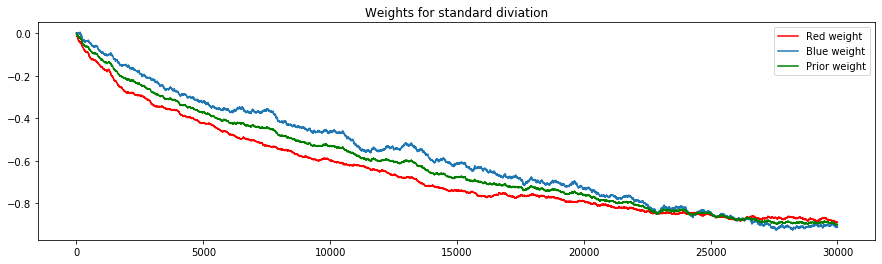

In [1425]:
fig = plt.figure(figsize=(15, 4))
plt.plot(std_weights_history[1:, 0], 'r', label='Red weight')
plt.plot(std_weights_history[1:, 1], label='Blue weight')
plt.plot(std_weights_history[1:, 2], 'g', label='Prior weight')
plt.legend()
plt.title('Weights for standard diviation')

Text(0.5, 0.98, 'Signal Mean Gradients')

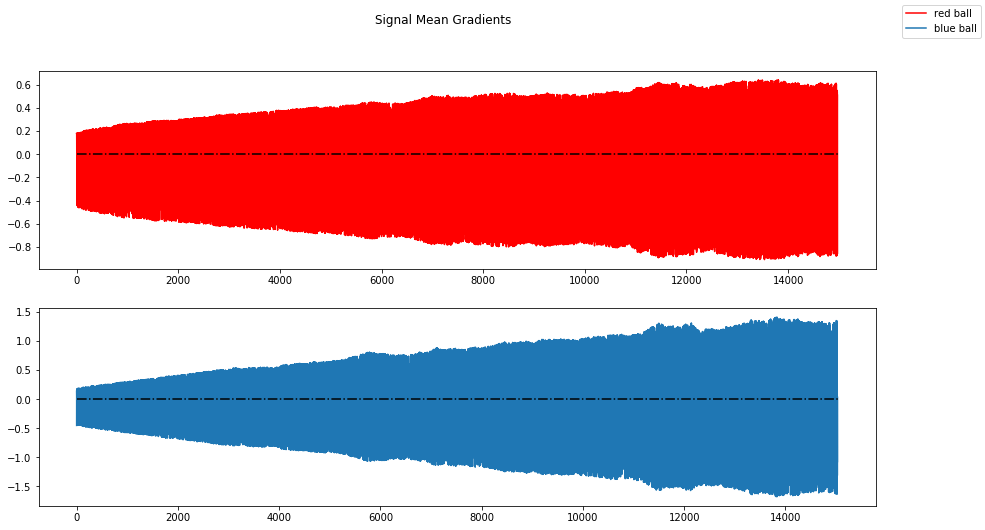

In [1426]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_mean_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients')

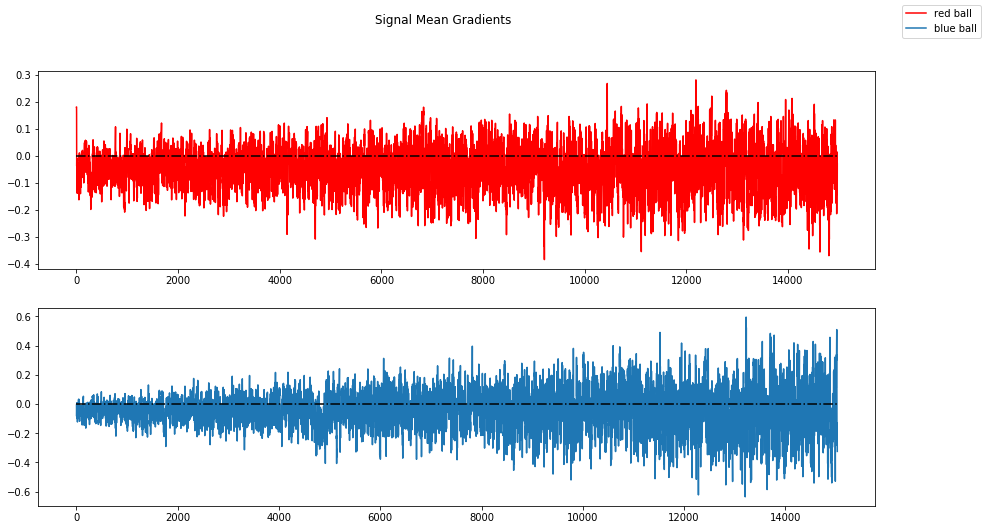

In [1427]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[1:, 0], 'r', label = 'red ball', zorder=-100)
axs[1].plot(grad_b_ball_v_mean_history[1:, 1],label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Signal Mean Gradients')

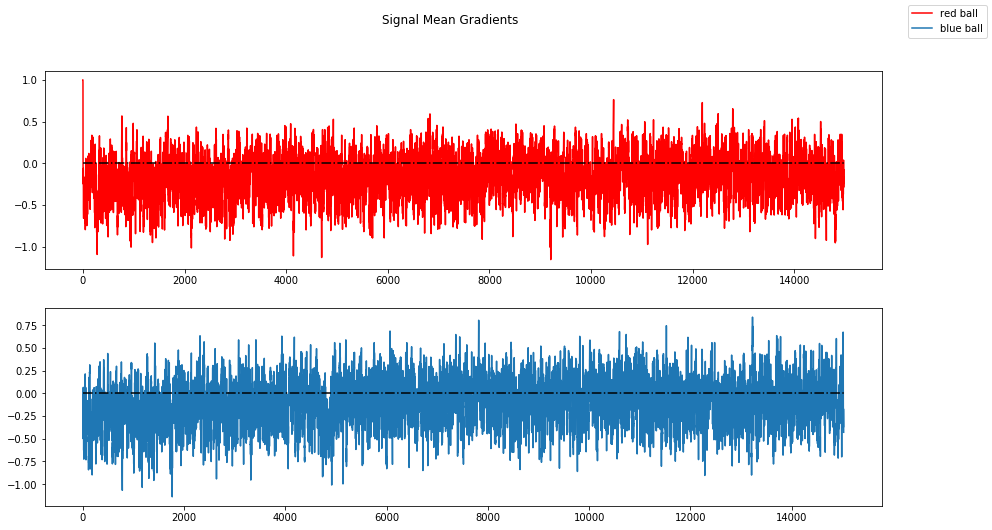

In [1428]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(np.divide(grad_r_ball_v_mean_history[1:, 0], np.sqrt(grad_r_ball_s_mean_history[1:, 0])), 'r', label = 'red ball', zorder=-100)
axs[1].plot(np.divide(grad_b_ball_v_mean_history[1:, 1], np.sqrt(grad_b_ball_s_mean_history[1:, 1])),label = 'blue ball', zorder=-100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Mean Gradients')

Text(0.5, 0.98, 'Prior Mean Gradient')

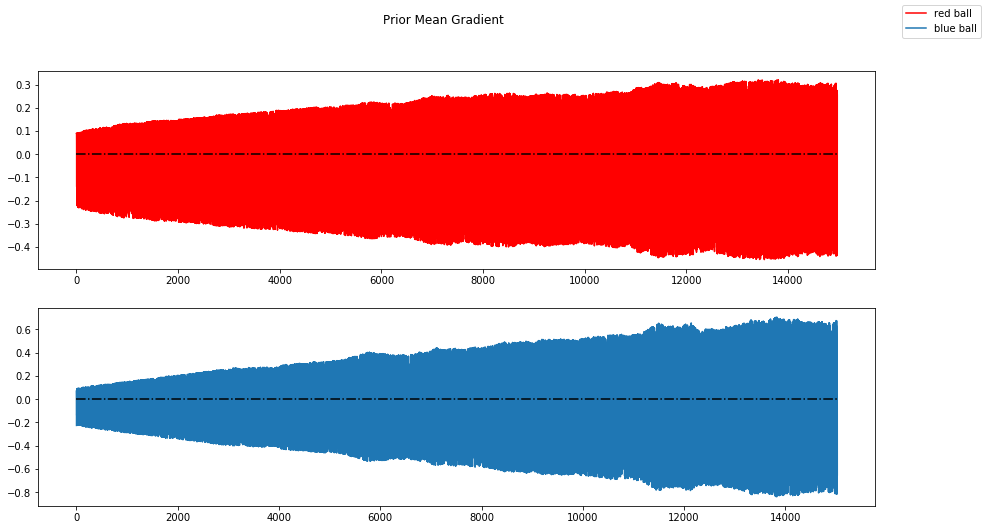

In [1429]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_mean_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_mean_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient')

Text(0.5, 0.98, 'Prior Mean Gradient')

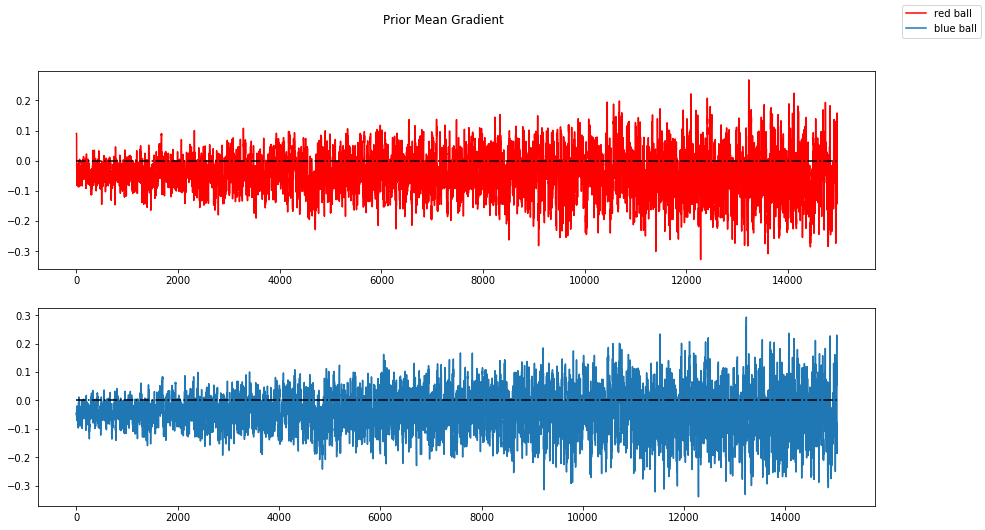

In [1430]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_mean_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_mean_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_mean_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Prior Mean Gradient')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient')

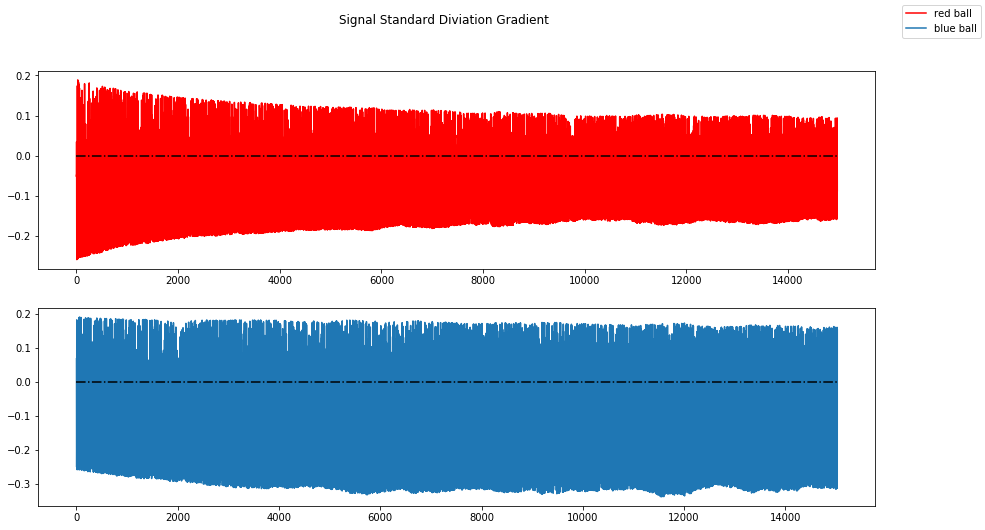

In [1431]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_std_history[1:, 2], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_std_history[1:, 2],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient')

Text(0.5, 0.98, 'Signal Standard Diviation Gradient')

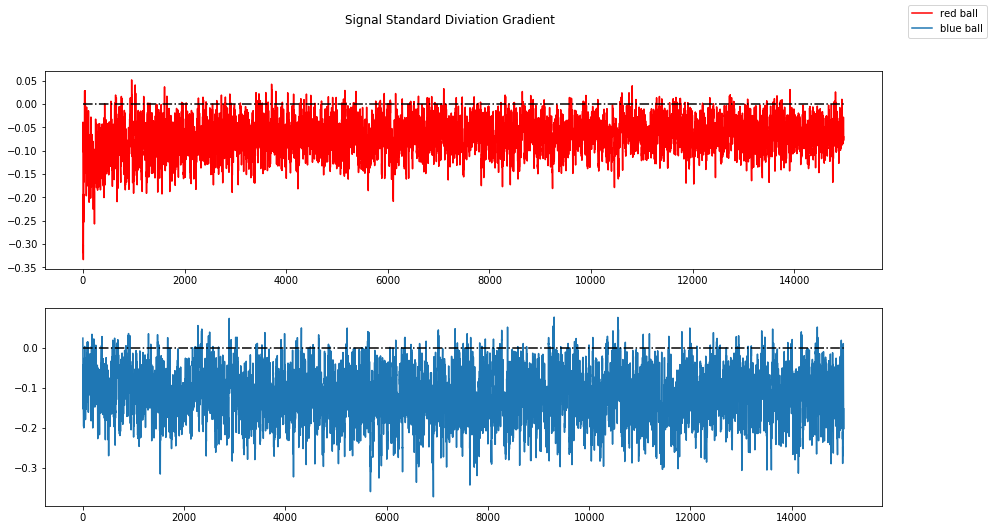

In [1432]:
fig, axs = plt.subplots(2, figsize=(15, 8))
axs[0].plot(grad_r_ball_v_std_history[1:, 0], 'r', label = 'red ball', zorder = -100)
axs[1].plot(grad_b_ball_v_std_history[1:, 1],label = 'blue ball', zorder = -100)
axs[0].hlines(y=0, xmin=0, xmax=grad_r_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
axs[1].hlines(y=0, xmin=0, xmax=grad_b_ball_v_std_history.shape[0], colors='black', linestyles='dashdot')
fig.legend()
fig.suptitle('Signal Standard Diviation Gradient')